In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import time

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)
import torch
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import glob
from pathlib import Path

from src.data_models.camels_ch import CamelsCH, CamelsCHConfig, get_all_gauge_ids
from src.data_models.dataset import HydroDataset
from src.data_models.preprocessing import (
    scale_time_series,
    scale_static_attributes,
    inverse_scale_static_attributes,
    inverse_scale_time_series,
)
from src.data_models.caravanify import Caravanify, CaravanifyConfig

from utils.metrics import nash_sutcliffe_efficiency
from src.data_models.datamodule import HydroDataModule

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from src.preprocessing.grouped import GroupedTransformer
from src.preprocessing.log_scale import LogTransformer
from src.preprocessing.standard_scale import StandardScaleTransformer

---

## Testing Caravanify

In [3]:
config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/timeseries/csv",
    gauge_id_prefix="CA",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)


caravan = Caravanify(config)
# ids_for_training = [
#     "CA_15016",
#     "CA_17462",
# ]
ids_for_training = caravan.get_all_gauge_ids()[:3]

print(f"Total number of stations: {len(ids_for_training)}")

caravan.load_stations(ids_for_training)


# Get data
ts_data = caravan.get_time_series()  
static_data = caravan.get_static_attributes()  

Total number of stations: 3


In [4]:
ts_data.columns

Index(['gauge_id', 'date', 'snow_depth_water_equivalent_mean',
       'surface_net_solar_radiation_mean',
       'surface_net_thermal_radiation_mean', 'surface_pressure_mean',
       'temperature_2m_mean', 'dewpoint_temperature_2m_mean',
       'u_component_of_wind_10m_mean', 'v_component_of_wind_10m_mean',
       'volumetric_soil_water_layer_1_mean',
       'volumetric_soil_water_layer_2_mean',
       'volumetric_soil_water_layer_3_mean',
       'volumetric_soil_water_layer_4_mean', 'snow_depth_water_equivalent_min',
       'surface_net_solar_radiation_min', 'surface_net_thermal_radiation_min',
       'surface_pressure_min', 'temperature_2m_min',
       'dewpoint_temperature_2m_min', 'u_component_of_wind_10m_min',
       'v_component_of_wind_10m_min', 'volumetric_soil_water_layer_1_min',
       'volumetric_soil_water_layer_2_min',
       'volumetric_soil_water_layer_3_min',
       'volumetric_soil_water_layer_4_min', 'snow_depth_water_equivalent_max',
       'surface_net_solar_radiati

In [5]:
ts_data["date"] = pd.to_datetime(ts_data["date"])

# Now we can get the day of year using dt accessor
ts_data["julian_day"] = ts_data["date"].dt.dayofyear

# Get column names excluding specific columns
ts_columns = [
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "streamflow",
    # "julian_day",
    "temperature_2m_mean",
    "total_precipitation_sum",
]

In [6]:
ts_data

,gauge_id,date,snow_depth_water_equivalent_mean,surface_net_solar_radiation_mean,surface_net_thermal_radiation_mean,surface_pressure_mean,temperature_2m_mean,dewpoint_temperature_2m_mean,u_component_of_wind_10m_mean,v_component_of_wind_10m_mean,...,v_component_of_wind_10m_max,volumetric_soil_water_layer_1_max,volumetric_soil_water_layer_2_max,volumetric_soil_water_layer_3_max,volumetric_soil_water_layer_4_max,total_precipitation_sum,potential_evaporation_sum_ERA5_LAND,potential_evaporation_sum_FAO_PENMAN_MONTEITH,streamflow,julian_day
0,CA_15013,2000-01-02,130.25,15.01,-9.28,71.16,-10.18,-13.73,0.95,1.99,...,2.73,0.34,0.35,0.35,0.38,5.97,0.13,0.24,0.63,2
1,CA_15013,2000-01-03,144.62,10.59,-11.76,71.11,-8.43,-9.87,1.72,0.54,...,1.44,0.34,0.35,0.35,0.38,20.43,-0.00,0.07,0.63,3
2,CA_15013,2000-01-04,167.69,13.05,-16.00,71.25,-9.37,-11.59,-0.24,0.83,...,1.76,0.34,0.35,0.35,0.38,20.20,0.12,0.03,0.63,4
3,CA_15013,2000-01-05,176.24,23.73,-41.70,71.20,-10.44,-15.85,-0.68,2.28,...,2.72,0.34,0.35,0.35,0.38,1.24,0.37,0.15,0.63,5
4,CA_15013,2000-01-06,176.33,25.52,-48.74,71.05,-13.20,-18.98,-0.77,2.42,...,2.93,0.34,0.34,0.35,0.38,0.04,0.28,0.12,0.63,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27388,CA_15020,2024-12-27,213.01,20.48,-36.81,67.37,-15.99,-25.31,-0.91,1.94,...,2.52,0.35,0.36,0.36,0.41,0.07,0.03,0.19,NaN,362
27389,CA_15020,2024-12-28,213.06,23.45,-49.38,67.32,-18.70,-25.35,-0.88,2.01,...,2.61,0.35,0.36,0.36,0.41,0.00,0.00,0.06,NaN,363
27390,CA_15020,2024-12-29,213.07,23.48,-40.60,67.00,-20.07,-28.59,-1.06,2.73,...,3.10,0.35,0.36,0.36,0.41,0.00,0.01,0.19,NaN,364
27391,CA_15020,2024-12-30,213.90,19.76,-19.28,66.92,-14.66,-24.10,-0.87,1.90,...,2.56,0.35,0.36,0.36,0.41,1.43,0.01,0.32,NaN,365


In [7]:
whole_data = ts_columns + ["gauge_id", "date"]
ts_data = ts_data[whole_data]

# # Group by gauge_id 
# grouped = ts_data.groupby("gauge_id")

# # Plot time series for each gauge of the ts_columns of the last 5 years
# for gauge_id, group in grouped:
#     group = group.set_index("date")
#     group = group.loc["2015-01-01":"2020-12-31"]
#     group[ts_columns].plot(subplots=True, figsize=(20, 20), title=gauge_id)
#     plt.show()



In [8]:
statics_to_keep = [
    "gauge_id",
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

static_columns = static_data.columns
static_columns = [col for col in list(static_columns) if col in statics_to_keep]

static_data = static_data[static_columns]
static_data

,gauge_id,area,cly_pc_sav,ele_mt_sav,slp_dg_sav,aridity_ERA5_LAND,aridity_FAO_PM,frac_snow,high_prec_dur,high_prec_freq,p_mean
0,CA_15013,254.786460,14.563168,2908.817796,174.240171,0.971101,0.531601,0.378615,1.139241,0.035202,2.243786
1,CA_15016,330.553623,12.462950,3332.875111,232.965619,0.430305,0.326681,0.445887,1.179641,0.025684,2.835258
2,CA_15020,310.918652,14.465533,3378.811981,256.956719,0.318642,0.265535,0.438106,1.256944,0.023598,3.604888


In [9]:
features = [
    col for col in ts_data.columns if col not in ["gauge_id", "date", "streamflow"]
]
ts_columns = features + ["streamflow"]  # Ensure target is not in features


# 1. Load and prepare CAMELS-CH data

In [10]:
# camels_config = CamelsCHConfig(
#     timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/timeseries/observation_based/",
#     timeseries_pattern="CAMELS_CH_obs_based_*.csv",
#     static_attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/static_attributes",
#     use_climate=False,
#     use_geology=False,
#     use_glacier=False,
#     use_human_influence=False,
#     use_hydrogeology=False,
#     use_hydrology=False,
#     use_landcover=False,
#     use_soil=False,
#     use_topographic=False,
# )

In [11]:
# all_gauge_ids = get_all_gauge_ids(camels_config)

# ids_for_training = all_gauge_ids[:5]

# camels = CamelsCH(camels_config)
# camels.load_stations(ids_for_training)

In [12]:
# data = camels.get_time_series()
# data = data[
#     [
#         "gauge_id",
#         "date",
#         "discharge_spec(mm/d)",
#     ]
# ]

# data

In [13]:
# static = camels.get_static_attributes()
# sc = static.columns

# # for i in range(len(sc)):
# #     print(f"{i}: {sc[i]}")
# static_attributes = [
#     "gauge_id",
#     "area", 
#     "elev_mean",  
#     "slope_mean",  
#     "aridity",  
#     "p_seasonality",  
#     "frac_snow",  
#     "porosity",  
#     "conductivity",  
#     "p_mean",  
#     "geo_porosity",  
# ]
# static = static[static_attributes]
# static

# 2. Configure preprocessing

In [14]:
dynamic_feature_cols = features
static_feature_cols = [c for c in static_columns if c != "gauge_id"]
target_cols = ["streamflow"]

# Feature pipeline: log + scale
feature_pipeline = Pipeline([
    # ("log", LogTransformer(columns=dynamic_feature_cols)),
    ("scaler", StandardScaleTransformer(columns=dynamic_feature_cols))
])

# Target pipeline: grouped by basin with log + scale
target_pipeline = GroupedTransformer(
    Pipeline([
        # ("log", LogTransformer(columns=target_cols)),
        ("scaler", StandardScaleTransformer(columns=target_cols))
    ]),
    columns=target_cols,
    group_identifier="gauge_id",
)

# Static feature pipeline: just scaling
static_pipeline = Pipeline([
    ("scaler", StandardScaleTransformer(columns=static_feature_cols))
])

# Define preprocessing configurations
preprocessing_configs = {
    "features": {
        "pipeline": feature_pipeline,
        "columns": dynamic_feature_cols
    },
    "target": {
        "pipeline": target_pipeline,
        "columns": target_cols
    },
    "static_features": {
        "pipeline": static_pipeline,
        "columns": static_feature_cols
    },
}

In [15]:
static_columns

['gauge_id',
 'area',
 'cly_pc_sav',
 'ele_mt_sav',
 'slp_dg_sav',
 'aridity_ERA5_LAND',
 'aridity_FAO_PM',
 'frac_snow',
 'high_prec_dur',
 'high_prec_freq',
 'p_mean']

# 3. Create DataModule

In [16]:
output_length = 10
input_length = 40

static_columns = [c for c in static_columns if c not in ["gauge_id"]]

print("TS columns:", ts_columns)
print("Static columns:", static_columns)


data_module = HydroDataModule(
    time_series_df=ts_data,
    static_df=static_data,
    # static_df=None,
    group_identifier="gauge_id",
    preprocessing_config=preprocessing_configs,
    batch_size=128,
    input_length=input_length,
    output_length=output_length,
    num_workers=4,
    features=ts_columns,
    static_features=static_columns,
    # static_features=None,
    target="streamflow",
    min_train_years=2,
    val_years=1,
    test_years=3,
    max_missing_pct=10,
    domain_id="CA",
)

data_module.prepare_data()
data_module.setup()
# train_loader = data_module.test_dataloader()

# for i, batch in enumerate(train_loader):
#     if i >= 6:  # Look at first 6 batches
#         break

#     print(f"Slice indeces: {batch['slice_idx']}")

TS columns: ['potential_evaporation_sum_ERA5_LAND', 'potential_evaporation_sum_FAO_PENMAN_MONTEITH', 'temperature_2m_mean', 'total_precipitation_sum', 'streamflow']
Static columns: ['area', 'cly_pc_sav', 'ele_mt_sav', 'slp_dg_sav', 'aridity_ERA5_LAND', 'aridity_FAO_PM', 'frac_snow', 'high_prec_dur', 'high_prec_freq', 'p_mean']
Original basins: 3
Retained basins: 2
Domain CA: Created 13254 valid sequences from 2 catchments
Domain CA: Created 632 valid sequences from 2 catchments
Domain CA: Created 2094 valid sequences from 2 catchments


In [17]:
static_columns

['area',
 'cly_pc_sav',
 'ele_mt_sav',
 'slp_dg_sav',
 'aridity_ERA5_LAND',
 'aridity_FAO_PM',
 'frac_snow',
 'high_prec_dur',
 'high_prec_freq',
 'p_mean']

In [18]:
data_module.target

'streamflow'

## 4. Create model and train

In [19]:
from src.models.lstm import LitLSTM
from src.models.ealstm import LitEALSTM
from src.models.TSMixer import LitTSMixer, TSMixerConfig
from src.models.evaluators import TSForecastEvaluator
from torch.optim import Adam
from torch.nn import MSELoss

# 5. Evalue and plot results

In [20]:
# model = LitLSTM(
#     input_size=len(ts_columns),
#     hidden_size=16,
#     num_layers=1,
#     output_size=output_length,
#     target=data_module.target,
# )

# model = LitEALSTM(
#     input_size_dyn=len(ts_columns),
#     input_size_stat=len(static_columns) - 1,
#     hidden_size=64,
#     output_size=output_length,
# )

config = TSMixerConfig(
    input_len=input_length,
    output_len=output_length,
    input_size=len(ts_columns),
    static_size=len(static_columns),
    hidden_size=80,
    learning_rate=7e-4,
    dropout=0.1,
    num_layers=2,
)

model = LitTSMixer(config)

# Configure trainer
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="cpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss",
            dirpath="checkpoints",
            filename="best-checkpoint",
            save_top_k=1,
            mode="min",
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min"),
        LearningRateMonitor(logging_interval="epoch"),
    ],
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Original basins: 3
Retained basins: 2
Domain CA: Created 13254 valid sequences from 2 catchments


/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/cooper/Desktop/CAMELS-CH/notebooks/checkpoints exists and is not empty.

  | Name          | Type    | Params | Mode 
--------------------------------------------------
0 | model         | TSMixer | 32.9 K | train
1 | mse_criterion | MSELoss | 0      | train
--------------------------------------------------
32.9 K    Trainable params
0         Non-trainable params
32.9 K    Total params
0.132     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


Domain CA: Created 632 valid sequences from 2 catchments


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [21]:
quality_report = data_module.quality_report

excluded_basins = list(quality_report["excluded_basins"].keys())
excluded_basins

ids_for_training = [id for id in ids_for_training if id not in excluded_basins]

In [22]:
quality_report

{'original_basins': 3,
 'retained_basins': 2,
 'excluded_basins': {'CA_15016': 'Exceeded maximum missing percentage (10%) in columns: streamflow (70.94%)'},
 'valid_periods': {'CA_15013': {'temperature_2m_mean': {'start': Timestamp('2000-01-02 00:00:00'),
    'end': Timestamp('2024-12-31 00:00:00')},
   'potential_evaporation_sum_FAO_PENMAN_MONTEITH': {'start': Timestamp('2000-01-02 00:00:00'),
    'end': Timestamp('2024-12-31 00:00:00')},
   'total_precipitation_sum': {'start': Timestamp('2000-01-02 00:00:00'),
    'end': Timestamp('2024-12-31 00:00:00')},
   'streamflow': {'start': Timestamp('2000-01-02 00:00:00'),
    'end': Timestamp('2022-12-31 00:00:00')},
   'potential_evaporation_sum_ERA5_LAND': {'start': Timestamp('2000-01-02 00:00:00'),
    'end': Timestamp('2024-12-31 00:00:00')}},
  'CA_15016': {'temperature_2m_mean': {'start': Timestamp('2000-01-02 00:00:00'),
    'end': Timestamp('2024-12-31 00:00:00')},
   'potential_evaporation_sum_FAO_PENMAN_MONTEITH': {'start': Timest

In [23]:
trainer.test(model, data_module)
raw_results = model.test_results

# Create evaluator and get metrics
evaluator = TSForecastEvaluator(
    data_module, horizons=list(range(1, model.config.output_len + 1))
)
results_df, overall_metrics, basin_metrics = evaluator.evaluate(raw_results)

# Get overall summary
overall_summary = evaluator.summarize_metrics(overall_metrics)

# Get per-basin summary
basin_summary = evaluator.summarize_metrics(basin_metrics, per_basin=True)

Original basins: 3
Retained basins: 2
Domain CA: Created 2094 valid sequences from 2 catchments


Testing: |          | 0/? [00:00<?, ?it/s]

In [24]:
overall_summary

,MSE,MAE,NSE,RMSE
horizon,,,,
1,0.138485,0.227744,0.939836,0.372135
2,0.184816,0.254647,0.919950,0.429903
3,0.230152,0.279291,0.900639,0.479741
4,0.272668,0.302980,0.882690,0.522177
5,0.298734,0.315302,0.871922,0.546565
6,0.341051,0.339480,0.854282,0.583995
7,0.383253,0.357520,0.836810,0.619074
8,0.437630,0.381899,0.814383,0.661536
9,0.489767,0.400128,0.793242,0.699833


In [25]:
basin_summary

MSE       MAE       NSE      RMSE
basin_id horizon                                        
CA_15013 1        0.205876  0.271550  0.918087  0.453736
         2        0.273724  0.310676  0.891091  0.523186
         3        0.340667  0.341111  0.864456  0.583667
         4        0.397678  0.362859  0.841776  0.630617
         5        0.434596  0.378749  0.827094  0.659239
         6        0.491177  0.405584  0.804592  0.700840
         7        0.554530  0.427166  0.779395  0.744668
         8        0.613071  0.445630  0.756112  0.782988
         9        0.690164  0.467046  0.725446  0.830761
         10       0.710332  0.476053  0.717424  0.842812
CA_15020 1        0.071093  0.183939  0.965754  0.266633
         2        0.095909  0.198618  0.954120  0.309691
         3        0.119636  0.217470  0.943195  0.345885
         4        0.147659  0.243100  0.930436  0.384264
         5        0.162871  0.251855  0.923866  0.403573
         6        0.190924  0.273377  0.911435  0.436949
         7        0.211976  0.287875  0.902416  0.460409
         8        0.262190  0.318168  0.880340  0.512045
         9        0.289369  0.333209  0.869292  0.537931
         10       0.306725  0.340964  0.862702  0.553827

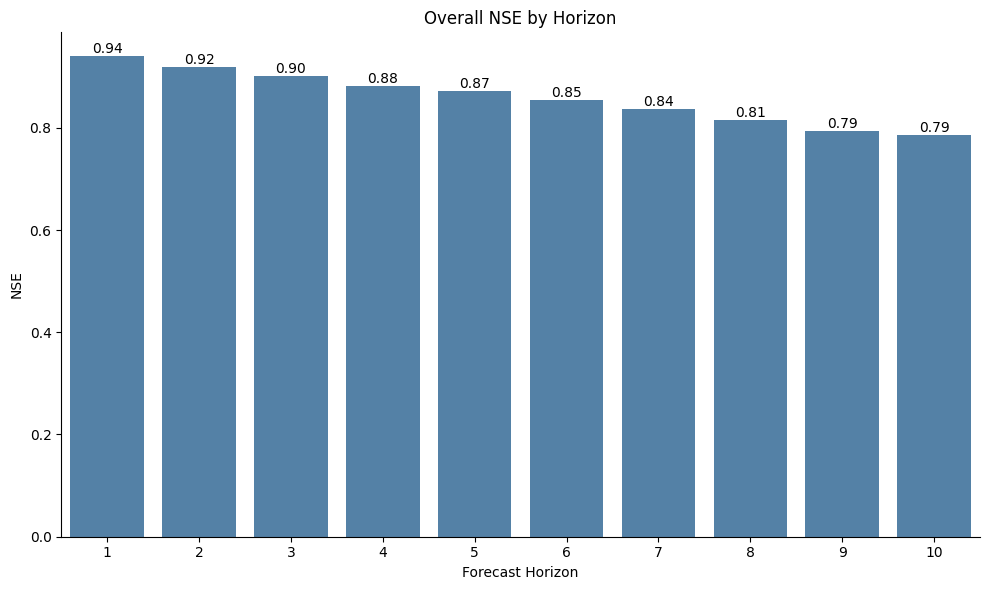

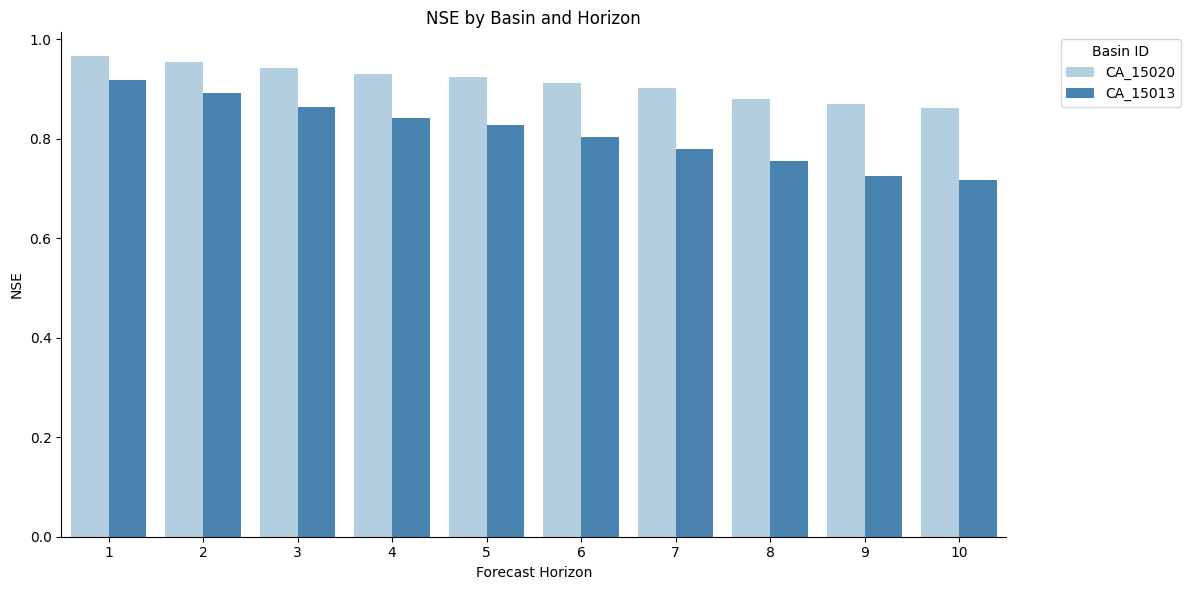

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_metric_summary(
    summary_df: pd.DataFrame, metric: str, per_basin: bool = False, figsize=(10, 6)
):
    plt.figure(figsize=figsize)

    if per_basin:
        df_plot = summary_df[metric].unstack(level=0)

        # Sort basins based on first horizon values
        first_horizon_values = df_plot.iloc[0]
        sorted_basins = first_horizon_values.sort_values(ascending=False).index
        df_plot = df_plot[sorted_basins]

        sns.barplot(
            data=df_plot.melt(ignore_index=False).reset_index(),
            x="horizon",
            y="value",
            hue="basin_id",
            palette="Blues",
        )
        plt.title(f"{metric} by Basin and Horizon")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Basin ID")

    else:
        ax = sns.barplot(x=summary_df.index, y=summary_df[metric], color="steelblue")
        plt.title(f"Overall {metric} by Horizon")

        for i, v in enumerate(summary_df[metric]):
            ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    plt.xlabel("Forecast Horizon")
    plt.ylabel(metric)
    plt.tight_layout()
    sns.despine()
    plt.show()


# Usage example:
plot_metric_summary(overall_summary, "NSE")  # Plot overall NSE
plot_metric_summary(
    basin_summary, "NSE", per_basin=True, figsize=(12, 6)
)  